In [1]:
import numpy as np

from pulse2percept import electrode2currentmap as e2cm
from pulse2percept import effectivecurrent2brightness as ec2b
from pulse2percept import oyster

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Create a retina
r_sampling = 100       # spatial sampling of retina
axon_lambda = 2        # constant that determines fall-off with axonal distance
rot = 4 * np.pi / 180  # retina rotation angle
retina = e2cm.Retina(sampling=r_sampling, axon_lambda=axon_lambda, rot=rot,
                     xlo=-3500, xhi=1500, ylo=-2500, yhi=2500)

File '../retina_s100_l2.0_rot4.0_5000x5000.npz' doesn't exist or has outdated parameter values, generating...


In [3]:
# Place an Argus I array on the retina
argus = e2cm.ArgusI(x_center=-1354.32, y_center=111.15, h=100, rot=np.pi/4)

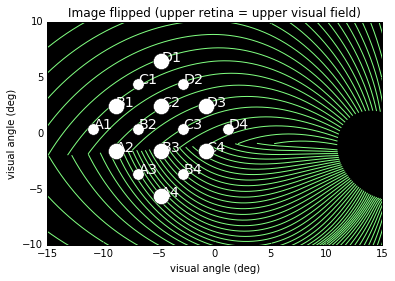

In [4]:
# Plot axon bundles (plot every 5th for the sake of visualization)
fig, ax = plt.subplots(1)
ax.set_axis_bgcolor('black')
ax.plot(retina.jan_x[:, ::5], -retina.jan_y[:, ::5], c=(0.5, 1, 0.5))

# Plot location of implant on top of axon bundles
for e in argus.electrodes:
    ax.text(e2cm.micron2deg(e.x_center + 10), e2cm.micron2deg(e.y_center + 5), e.name,
            color='white', size='x-large')
    ax.plot(e2cm.micron2deg(e.x_center), e2cm.micron2deg(e.y_center), 'ow',
            markersize=np.sqrt(e.radius))
ax.set_aspect('equal')
ax.set_xlim(-15, 15)
ax.set_xlabel('visual angle (deg)')
ax.set_ylim(-10, 10)
ax.set_ylabel('visual angle (deg)')
ax.set_title('Image flipped (upper retina = upper visual field)')
fig.savefig('jansonius_argusI.eps')

In [5]:
# Stimulation params
tsample = 0.005 / 1000  # Sample step (s)
dur = 0.05              # Stimulation duration (s)

# The temporal model contains the cascade of operations that leads from pulse to percept:
tm = ec2b.TemporalModel(tsample)

In [6]:
# Generate a list of pulse trains, one for each electrode
# Initialize all with zeros
pt = [e2cm.Psycho2Pulsetrain(tsample, freq=0, amp=0, dur=dur)] * argus.num_electrodes

# Stimulate B3
idx_B3 = argus.get_index('B3')
pt[idx_B3] = e2cm.Psycho2Pulsetrain(tsample, freq=50, amp=20, dur=dur)

# Stimulate C1
idx_C1 = argus.get_index('C1')
pt[idx_C1] = e2cm.Psycho2Pulsetrain(tsample, freq=50, amp=20, dur=dur)

In [7]:
mov = ec2b.pulse2percept(pt, argus, 'NFL', retina, tm, n_jobs=8, dojit=True, tol=0.01)

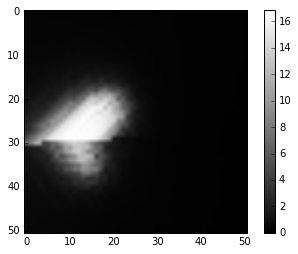

In [8]:
frame = ec2b.get_brightest_frame(mov)
plt.imshow(frame.data, cmap='gray')
plt.colorbar()